In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib as mpl
import pandas as pd
import numpy as np
from iminuit import Minuit
from scipy import stats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os, sys
sys.path.append('..')
from functions import read_data, overview_plot_leak, dict_for_treatment, fit_exp, plot_fit
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, nice_string_output, add_text_to_ax

In [2]:
path = '../../../KU/Bachelor+Research/Data/Axetris/Own setup/'

leak_test = read_data(path)

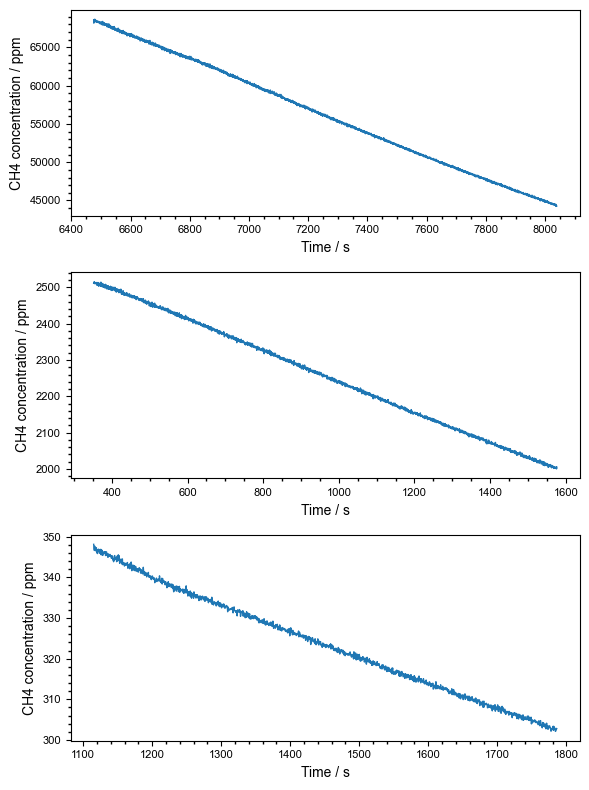

In [3]:
fig, ax = plt.subplots(3,1, figsize = (6, 8))

overview_plot_leak(ax[0], leak_test['Leak_test1_05032024'][4400:7600])
overview_plot_leak(ax[1], leak_test['Leak_test2_05032024'][700:-1])
overview_plot_leak(ax[2], leak_test['Leak_test3_07032024'][1300:])

fig.tight_layout()
fig.savefig('leak_test.png', dpi = 600)
plt.show()

In [ ]:
idx_leak = np.array([[4400, 7600], [700, -1], [1300, -1]])

leak_treat = dict_for_treatment(leak_test, idx_leak)

In [5]:
a_guess = [-1, -1, -1]
b_guess = [65000, 2000, 300]
array_a, array_b, array_ea, array_eb, array_Chi2, array_ndf, array_Prob = fit_exp(leak_treat, a_guess, b_guess)

Leak_test1_05032024  Fit: a=-0.016749+-0.00001053  b=69407.175+-9.787  p=0.000000
Leak_test2_05032024  Fit: a=-0.011281+-0.00037635  b=2526.749+-10.555  p=1.000000
Leak_test3_07032024  Fit: a=-0.012099+-0.00647119  b=346.064+-13.952  p=1.000000


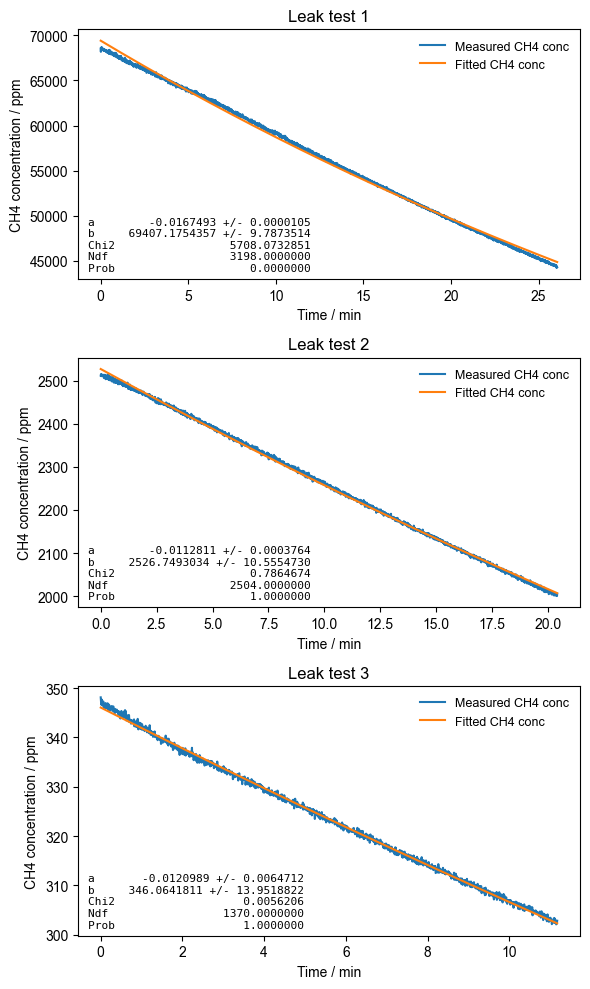

In [6]:
fig, ax = plt.subplots(3, 1, figsize = (6, 10))

for i, key in enumerate(leak_treat.keys()):
    plot_fit(ax[i], leak_treat[key], array_a[i], array_b[i], array_ea[i], array_eb[i], array_Chi2[i], array_ndf[i], array_Prob[i])
ax[0].set_title('Leak test 1')
ax[1].set_title('Leak test 2')
ax[2].set_title('Leak test 3')

fig.tight_layout()
fig.savefig('Fitted_leak.png', dpi = 600)
plt.show()